In [6]:
import pandas as pd
import sqlite3

In [10]:
conn = sqlite3.connect("news.db")
c = conn.cursor()

In [18]:

# get news headlines
query = """
    SELECT ArticleContent.headline, ArticleMeta.news_datetime
    FROM ArticleContent
    INNER JOIN ArticleMeta
    ON ArticleContent.id = ArticleMeta.id
"""
c.execute(query)
result = c.fetchall()

In [19]:
df_headlines = pd.DataFrame(result, columns=['headline', 'datetime'])

In [21]:
from datetime import datetime

In [31]:
datetime_pattern = "%Y-%m-%d %H:%M:%S"
datetime.strptime("2022-11-05 07:22:00", datetime_pattern)

datetime.datetime(2022, 11, 5, 7, 22)

In [32]:
df_headlines['datetime'] = df_headlines['datetime'].apply(lambda x: datetime.strptime(x, datetime_pattern))

In [89]:
with open("data/news/headline.csv", 'w') as f:
    f.writelines([line + "\n" for line in df_headlines['headline'] if line])


In [48]:
## Latent Dirichlet Allocation
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [49]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [59]:
data_samples = df_headlines['headline'].to_list()

In [82]:
[sample.split(':') for sample in data_samples]

[['Dow Jones- & NASDAQ-Werte',
  ' Amazon-Aktie, Microsoft-Aktie, NVIDIA-Aktie & Co. im Fokus',
  ' Das sind die Bilanzen der Tech-Riesen in der aktuellen Saison'],
 ['Amazon-Aktie in Grün',
  ' Neues Logistikzentrum in Helmstedt offiziell eröffnet'],
 ['Was Analysten von der Amazon-Aktie erwarten'],
 ['Amazon-Aktie schwächelt',
  ' Amazon verhängt Einstellungsstopp - Ungewisse Wirtschaftslage'],
 ['Aufgewertetes Prime-Abo',
  ' Amazon greift Spotify und Apple Music an - Amazon-Aktie tiefrot'],
 ['Darum ist es für Investoren oft ein Fehler frühzeitig Gewinne mitzunehmen'],
 ['Amazon-Aktie schließt tiefrot aber über Tagestiefs',
  ' Amazon enttäuscht bei Umsatz und Ausblick'],
 ['Ausblick', ' Amazon verkündet Quartalsergebnis zum jüngsten Jahresviertel'],
 ['Alibaba-Chef Jack Ma',
  ' Vom Verlierertyp zum Milliardär - Warum sich Aufgeben nicht lohnt'],
 ['Amazon-Aktie steigt', ' Amazon verwendet erstmals Airbus-Frachtflugzeuge'],
 ['Amazon-Aktie fester',
  ' Amazon geht mit Klage gegen 

In [70]:
from nltk import word_tokenize

In [76]:
word_tokenize("Das ist ein Satz", language='german')

['Das', 'ist', 'ein', 'Satz']

In [77]:
from nltk import WordNetLemmatizer

In [78]:
wnl = WordNetLemmatizer()

In [79]:
wnl.lemmatize("worlds")

LookupError: 
**********************************************************************
  Resource [93momw-1.4[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('omw-1.4')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/omw-1.4[0m

  Searched in:
    - '/home/malte/nltk_data'
    - '/home/malte/anaconda3/nltk_data'
    - '/home/malte/anaconda3/share/nltk_data'
    - '/home/malte/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [69]:
data_samples

['Dow Jones- & NASDAQ-Werte: Amazon-Aktie, Microsoft-Aktie, NVIDIA-Aktie & Co. im Fokus: Das sind die Bilanzen der Tech-Riesen in der aktuellen Saison',
 'Amazon-Aktie in Grün: Neues Logistikzentrum in Helmstedt offiziell eröffnet',
 'Was Analysten von der Amazon-Aktie erwarten',
 'Amazon-Aktie schwächelt: Amazon verhängt Einstellungsstopp - Ungewisse Wirtschaftslage',
 'Aufgewertetes Prime-Abo: Amazon greift Spotify und Apple Music an - Amazon-Aktie tiefrot',
 'Darum ist es für Investoren oft ein Fehler frühzeitig Gewinne mitzunehmen',
 'Amazon-Aktie schließt tiefrot aber über Tagestiefs: Amazon enttäuscht bei Umsatz und Ausblick',
 'Ausblick: Amazon verkündet Quartalsergebnis zum jüngsten Jahresviertel',
 'Alibaba-Chef Jack Ma: Vom Verlierertyp zum Milliardär - Warum sich Aufgeben nicht lohnt',
 'Amazon-Aktie steigt: Amazon verwendet erstmals Airbus-Frachtflugzeuge',
 'Amazon-Aktie fester: Amazon geht mit Klage gegen gefälschte Bewertungen vor',
 'Beim Streamen von Musik, Filmen und 

In [67]:
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features
)
tfidf = tfidf_vectorizer.fit_transform(data_samples)

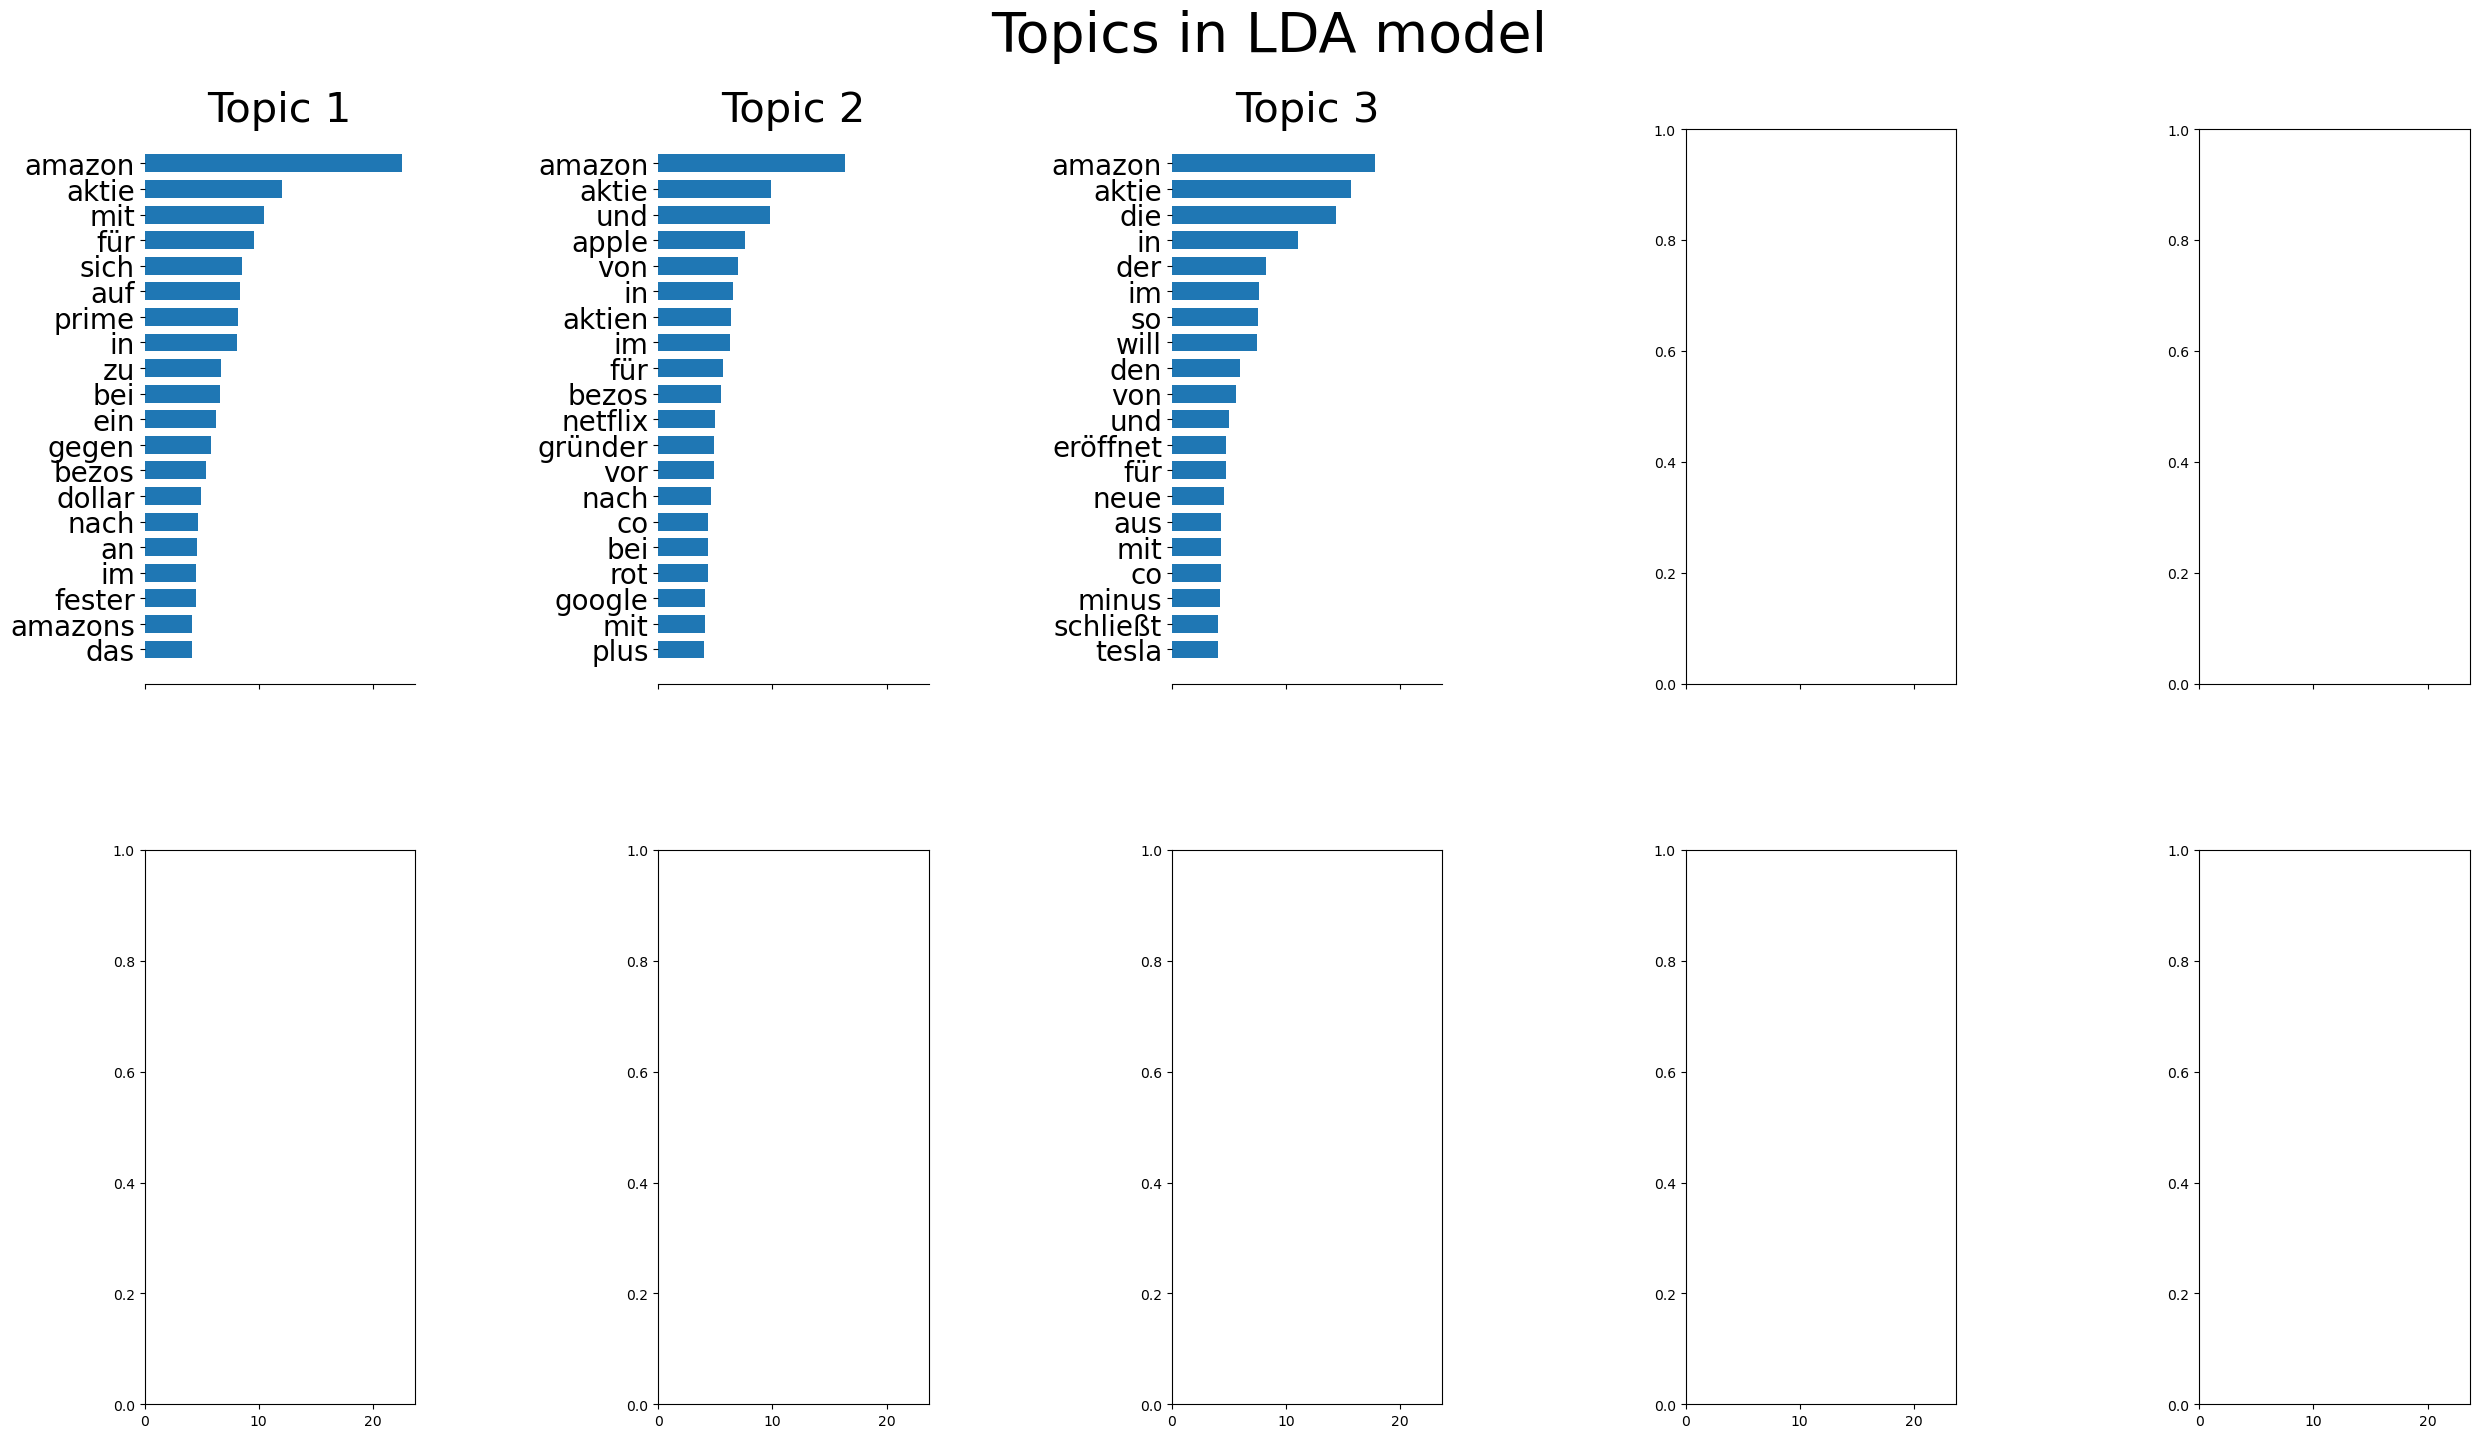

In [68]:
lda = LatentDirichletAllocation(
    n_components=3,
    max_iter=5,
)
lda.fit(tfidf)

tf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")